**Deep Learning**

**Practice 3.1 - VAE**

**Marcelo Ferrer - Aymen Merchaoui**


## 1. Imports, declarations and configuration

In this section we define the necessary imports, declarations and configuration to run the application. 

In [1]:
# Verify that GPU is active
import tensorflow as tf

gpu_active = tf.config.list_physical_devices('GPU')

if (len(gpu_active) == 0):
    print("NO GPU ACTIVE!!!")
else:
    print("Using GPU")

Using GPU


In [2]:
import os

# For better visualization of convolutional models
os.system("pip install visualkeras")

0

In [3]:
import numpy as np
import glob, os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import visualkeras
from keras.utils import plot_model
import cv2

In [4]:
# Disable eager execution (eager execution executes TensorFlow operations immediately)
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [5]:
# Mat plot workaround
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## 2.Load dataset

Load the images

In [6]:
DATA_FOLDER = "dataset/img_align_celeba/"
DATA_FOLDER_TRAIN = "dataset/img_align_celeba_train/"
WEIGHTS_FOLDER = 'dataset/weights/'

if not os.path.exists(WEIGHTS_FOLDER):
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

filenames = np.array(glob.glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


In [7]:
INPUT_DIM = (128,128,1) # Image dimension
BATCH_SIZE = 512 # Size of the batch

# Normalization from 0 to 1
data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
    target_size = INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = 'training',
    color_mode='grayscale'
    )

# Normalization from 0 to 1 for a 100.000 train dataset
data_flow_train = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER_TRAIN, 
    target_size = INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = 'training',
    color_mode='grayscale'
    )

Found 202599 images belonging to 1 classes.
Found 100000 images belonging to 1 classes.


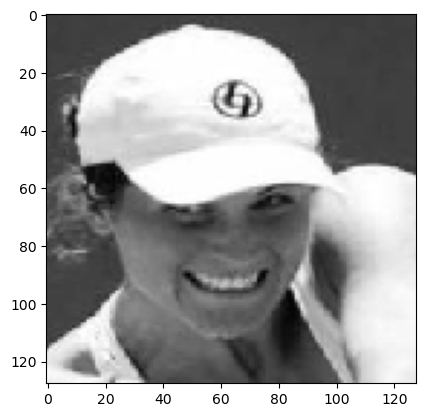

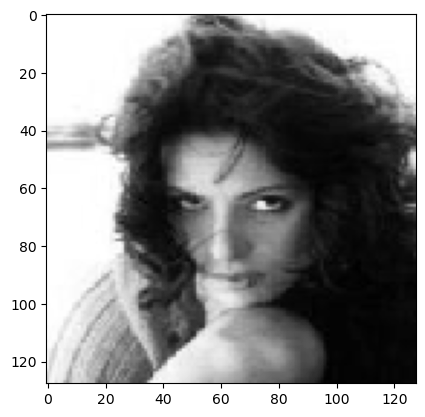

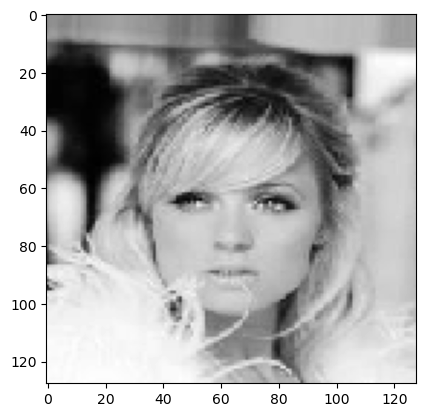

In [8]:
# Display some example images
batch = data_flow_train.next()
for i in range(0,3):
    image = batch[0][i]

    plt.imshow(image, cmap='gray')
    plt.show()

## 3.Test models

### Functions and constants

In [9]:
LEARNING_RATE = 0.0005 # Learning rate of the optimizer
N_EPOCHS = 8 #2  # No. of epochs to show advance
N_BLOCKS = 15 #20 # Number of blocks to run (total epochs = N_EPOCHS * N_BLOCKS)
LOSS_FACTOR = 10000 # To control the importance of the reconstruction or KL losses in the total loss function
Z_DIM = 200 # Dimension of the latent vector (z)

In [10]:
def plot_compare_VAE(encoder,decoder,model,images, add_noise=False):
    n_to_show = images.shape[0]

    if add_noise:
        encodings = encoder.predict(images)
        encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
        reconst_images = decoder.predict(encodings)
    else:
        reconst_images = model.predict(images)

    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)

    for i in range(n_to_show):
        #img = images[i].squeeze()
        img = images[i]
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img,cmap='gray')

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img,cmap='gray')
    plt.show()

In [11]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, conv_strides):
  
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()
    
    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'encoder_conv_' + str(i)
            )(x)

        x = LeakyReLU()(x)
        
    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 
    
    x = Flatten()(x)
    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)

    # Defining a function for sampling
    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   

    # Using a Keras Lambda Layer to include the sampling function as a layer in the model
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

In [12]:
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(
            filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'decoder_conv_' + str(i)
            )(x)
        
        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

In [13]:
def plot_losses(hist_loss, hist_r_loss, hist_kl_loss):
    f_hist_loss = []
    for h in hist_loss:
        for v in h:
            f_hist_loss.append(v)

    f_hist_r_loss = []
    for h in hist_r_loss:
        for v in h:
            f_hist_r_loss.append(v)

    f_hist_kl_loss = []
    for h in hist_kl_loss:
        for v in h:
            f_hist_kl_loss.append(v)

    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    # Plot the data on each subplot
    ax1.plot(f_hist_loss)
    ax2.plot(f_hist_r_loss)
    ax3.plot(f_hist_kl_loss)

    # Add titles to each subplot
    ax1.set_title('Total Loss')
    ax2.set_title('Reconstruction loss')
    ax3.set_title('Kullback-Leibler loss')

    plt.show()

### First model

In [14]:
conv_filters_enc = [16, 32, 32, 32]
conv_kernel_size_enc = [3,3,3,3]
conv_strides_enc = [2,2,2,2]
conv_filters_dec = [32,32,16,1]
conv_kernel_size_dec = [3,3,3,3]
conv_strides_dec = [2,2,2,2]

In [15]:
# Creates the encoder with the size and filters passed in the parameters
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder = build_vae_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    conv_filters = conv_filters_enc,
    conv_kernel_size = conv_kernel_size_enc,
    conv_strides = conv_strides_enc)

# Generate the decoder, as a backward mirror of the encoder
decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = vae_shape_before_flattening,      
    conv_filters = conv_filters_dec,
    conv_kernel_size = conv_kernel_size_dec,
    conv_strides = conv_strides_dec
    )

# Generate the model with the encoder and the decoder
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
model = Model(vae_input, vae_output)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 32)   4640        ['leaky_re_lu[0][0]']        

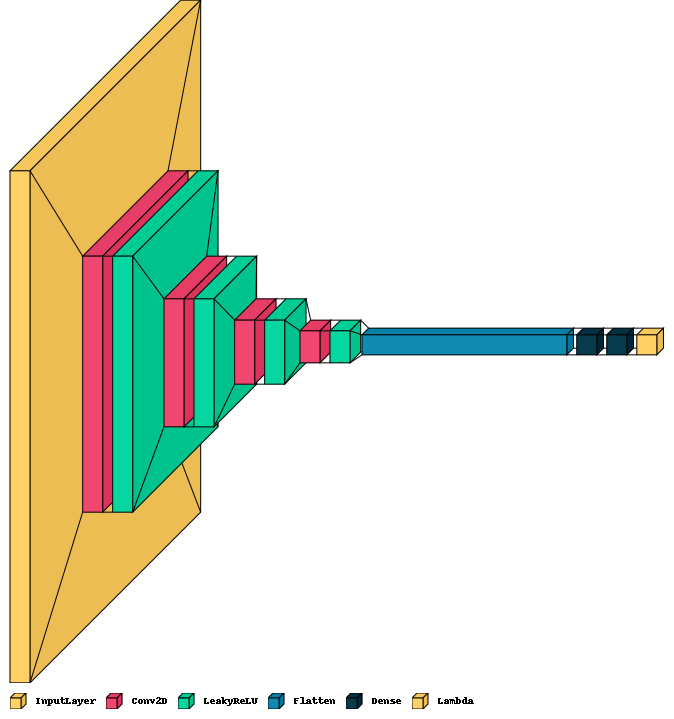

In [16]:
vae_encoder.summary()

visualkeras.layered_view(vae_encoder, legend=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 2048)              411648    
                                                                 
 reshape (Reshape)           (None, 8, 8, 32)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 16, 16, 32)       9248      
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 32, 32, 32)       9248      
 pose)                                                     

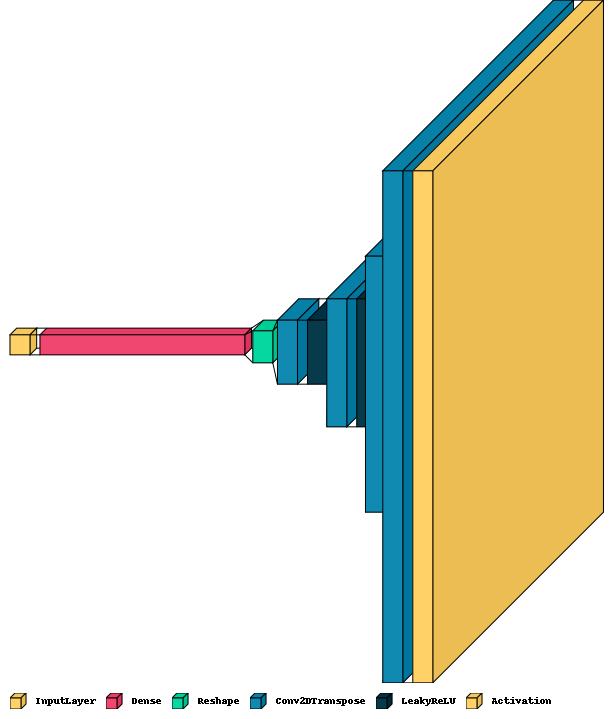

In [17]:
vae_decoder.summary()

visualkeras.layered_view(vae_decoder, legend=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 32)   4640        ['leaky_re_lu[0][0]']      

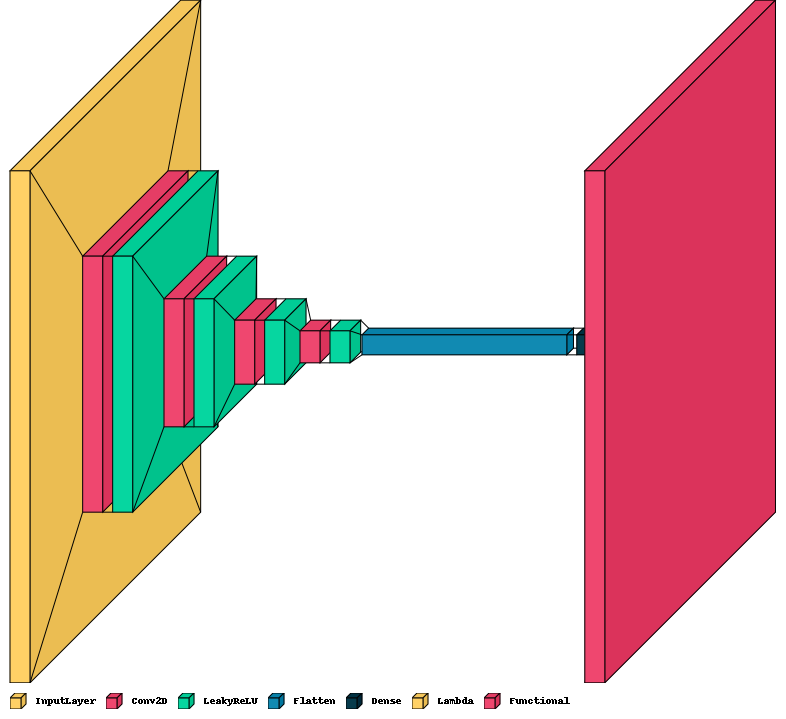

In [18]:
model.summary()

visualkeras.layered_view(model, legend=True)

395/395 [==============================] - 555s 1s/step - batch: 197.5000 - size: 510.2222 - loss: 370.1244 - r_loss: 0.0323 - kl_loss: 46.8554


c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


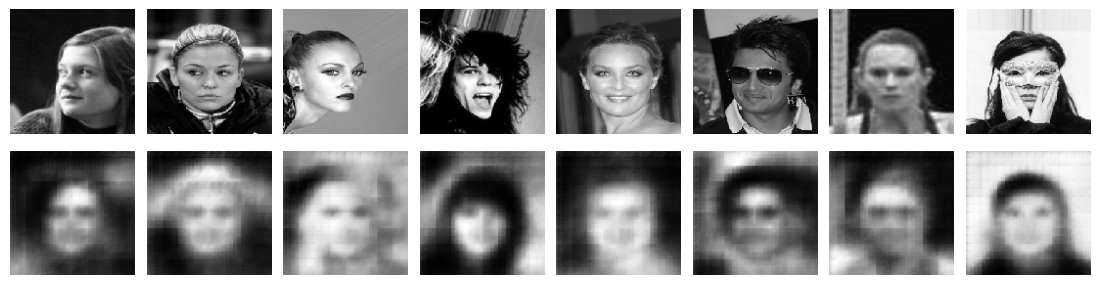

In [19]:
# Reconstruction loss, the mean squared error between the input and output images
# Measures how well the VAE is able to reconstruct the input data from the learned latent representation
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

# KL divergence loss, calculates the divergence between the learned distribution and the prior.
# Used next for calculating the total_loss
# Measures the regularity of the learned latent representation
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

# Total loss, weighted sum of the reconstruction loss and the KL divergence loss (LOSS_FACTOR is configurable)
def total_loss(y_true, y_pred):
    return LOSS_FACTOR * r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

hist_loss = []
hist_r_loss = []
hist_kl_loss = []

adam_optimizer = Adam(learning_rate = LEARNING_RATE)

model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

# Takes 8 images to show the results during training
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:8]

# Just run one epoch and plot the images
model.fit(data_flow_train, 
    shuffle=True, 
    epochs = 1, 
    initial_epoch = 0, 
    steps_per_epoch=NUM_IMAGES / BATCH_SIZE)

plot_compare_VAE(vae_encoder, vae_decoder, model, example_images,False) 
# lr=0.0005 = 25min

Total Epoch: 0
Epoch 1/8
395/395 [==============================] - 140s 354ms/step - batch: 197.5000 - size: 510.2222 - loss: 227.7412 - r_loss: 0.0174 - kl_loss: 53.4549
Epoch 2/8
395/395 [==============================] - 153s 387ms/step - batch: 197.5000 - size: 510.2222 - loss: 205.6313 - r_loss: 0.0153 - kl_loss: 52.7752
Epoch 3/8
395/395 [==============================] - 149s 375ms/step - batch: 197.5000 - size: 510.2222 - loss: 198.8108 - r_loss: 0.0145 - kl_loss: 53.8197
Epoch 4/8
395/395 [==============================] - 147s 370ms/step - batch: 197.5000 - size: 510.2222 - loss: 195.3217 - r_loss: 0.0141 - kl_loss: 54.5993
Epoch 5/8
395/395 [==============================] - 163s 412ms/step - batch: 197.5000 - size: 510.2222 - loss: 192.6928 - r_loss: 0.0138 - kl_loss: 55.1344
Epoch 6/8
395/395 [==============================] - 151s 382ms/step - batch: 197.5000 - size: 510.2222 - loss: 190.7957 - r_loss: 0.0135 - kl_loss: 55.4354
Epoch 7/8
395/395 [========================

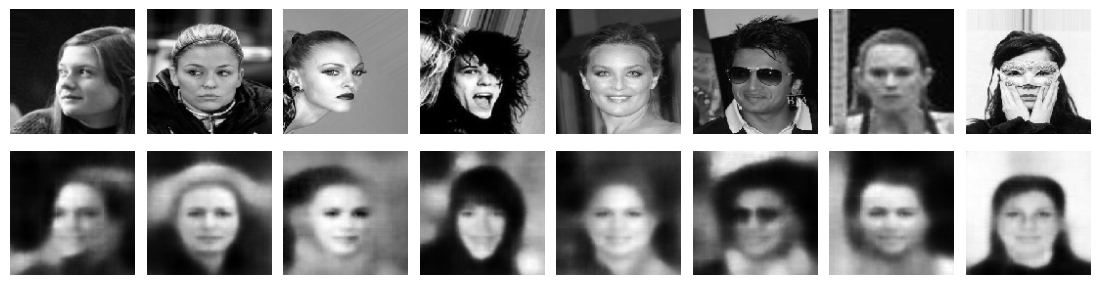

TypeError: can only concatenate str (not "int") to str

In [20]:
tot_epoch = 0
# For each block train the model for a number of epochs and show the partial images
for i in range(N_BLOCKS):
    print("Total Epoch:", tot_epoch)
    hist = model.fit(data_flow_train, 
        shuffle=True, 
        epochs = N_EPOCHS, 
        initial_epoch = 0, 
        steps_per_epoch=NUM_IMAGES / BATCH_SIZE)
    hist_loss.append(hist.history['loss'])
    hist_r_loss.append(hist.history['r_loss'])
    hist_kl_loss.append(hist.history['kl_loss'])

    plot_compare_VAE(vae_encoder, vae_decoder, model, example_images, False) 

    # Save the model in case we want to use it later
    model.save(os.path.join(WEIGHTS_FOLDER, 'VAE/model_1_' + str(tot_epoch) + '.h5'))

    tot_epoch = tot_epoch + N_EPOCHS

#lr=0.0005=597,180 - 120 epochs=360 min

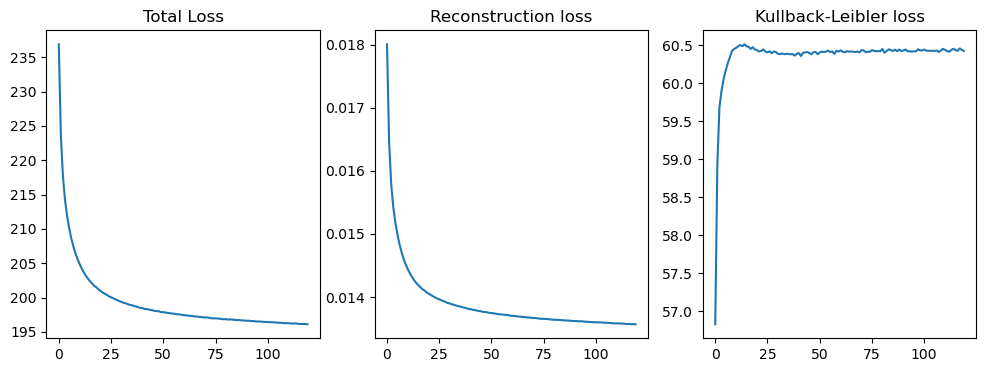

In [21]:
plot_losses(hist_loss, hist_r_loss, hist_kl_loss)

### Second model

In [22]:
# More filters and a extra layer
conv_filters_enc = [32, 64, 64, 64, 64]
conv_kernel_size_enc = [3,3,3,3]
conv_strides_enc = [2,2,2,2]
conv_filters_dec = [64,64,64,32,3]
conv_kernel_size_dec = [3,3,3,3]
conv_strides_dec = [2,2,2,2]

### Third model

In [23]:
# Same model reducing the Z
Z_DIM = 100 # Dimension of the latent vector (z)

### Four model

In [24]:
# Same model with black and white images
conv_filters_enc = [16, 32, 32, 32]
conv_kernel_size_enc = [3,3,3,3]
conv_strides_enc = [2,2,2,2]
conv_filters_dec = [32,32,16,1]
conv_kernel_size_dec = [3,3,3,3]
conv_strides_dec = [2,2,2,2]

### Fifth model

In [25]:
# Same model with bigger kernel size
conv_filters_enc = [16, 32, 32, 32]
conv_kernel_size_enc = [5,5,5,5]
conv_strides_enc = [2,2,2,2]
conv_filters_dec = [32,32,16,1]
conv_kernel_size_dec = [5,5,5,5]
conv_strides_dec = [2,2,2,2]

In [26]:
# TODO add early stopping

In [27]:
# TODO try different learning rate and batch size, just to say if it go faster or not


In [28]:
# TODO understand when to stop training

In [29]:
# TODO use noise

### Color model

In [ ]:
conv_filters_enc = [16, 32, 32, 32]
conv_kernel_size_enc = [3,3,3,3]
conv_strides_enc = [2,2,2,2]
conv_filters_dec = [32,32,16,3]
conv_kernel_size_dec = [3,3,3,3]
conv_strides_dec = [2,2,2,2]

In [ ]:
# Creates the encoder with the size and filters passed in the parameters
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder = build_vae_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    conv_filters = conv_filters_enc,
    conv_kernel_size = conv_kernel_size_enc,
    conv_strides = conv_strides_enc)

# Generate the decoder, as a backward mirror of the encoder
decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = vae_shape_before_flattening,      
    conv_filters = conv_filters_dec,
    conv_kernel_size = conv_kernel_size_dec,
    conv_strides = conv_strides_dec
    )

# Generate the model with the encoder and the decoder
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
model = Model(vae_input, vae_output)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 16)   448         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 32)   4640        ['leaky_re_lu[0][0]']        

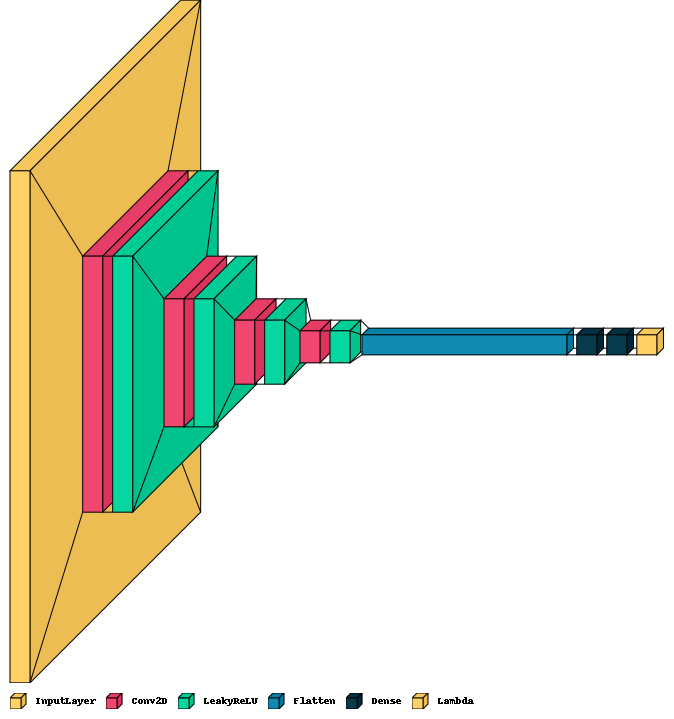

In [ ]:
vae_encoder.summary()

visualkeras.layered_view(vae_encoder, legend=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 2048)              411648    
                                                                 
 reshape (Reshape)           (None, 8, 8, 32)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 16, 16, 32)       9248      
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 32, 32, 32)       9248      
 pose)                                                     

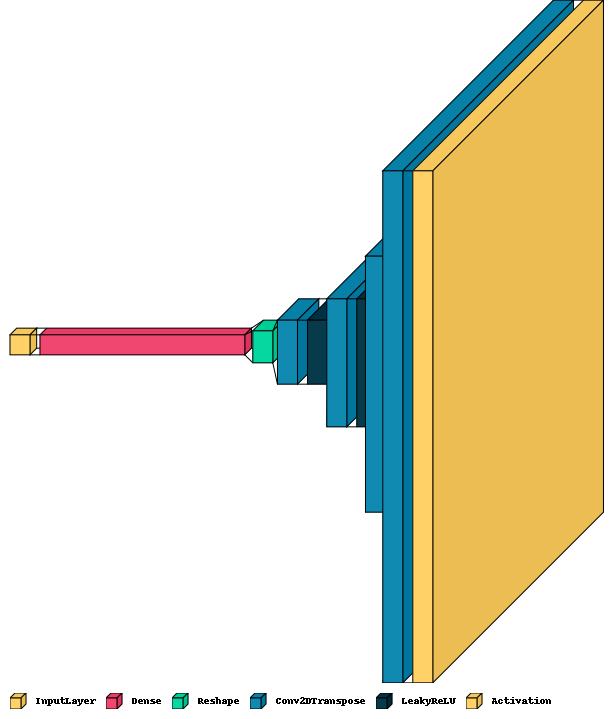

In [ ]:
vae_decoder.summary()

visualkeras.layered_view(vae_decoder, legend=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 16)   448         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 32)   4640        ['leaky_re_lu[0][0]']      

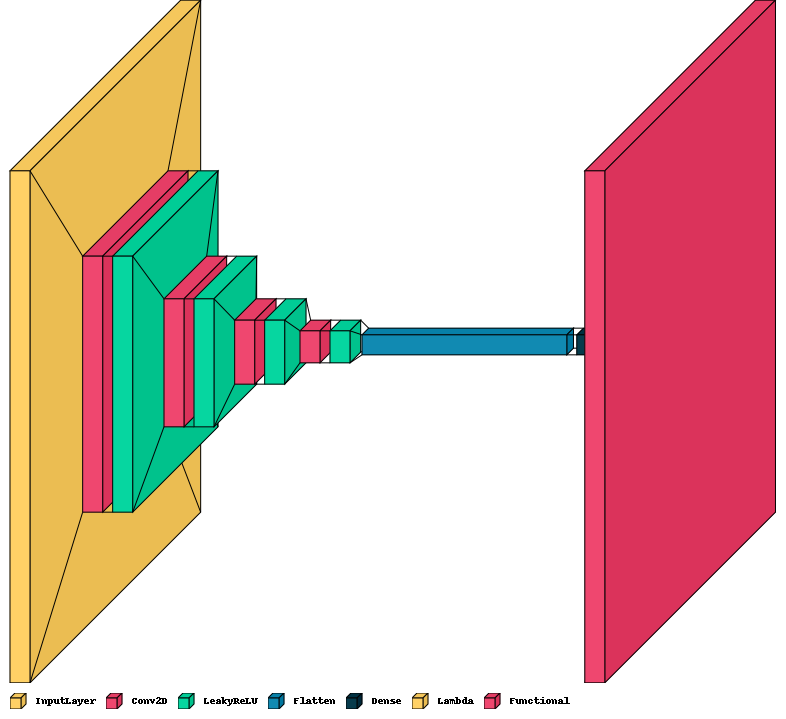

In [ ]:
model.summary()

visualkeras.layered_view(model, legend=True)

791/791 [==============================] - 1704s 2s/step - batch: 395.5000 - size: 255.8068 - loss: 362.4195 - r_loss: 0.0313 - kl_loss: 49.1849


c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


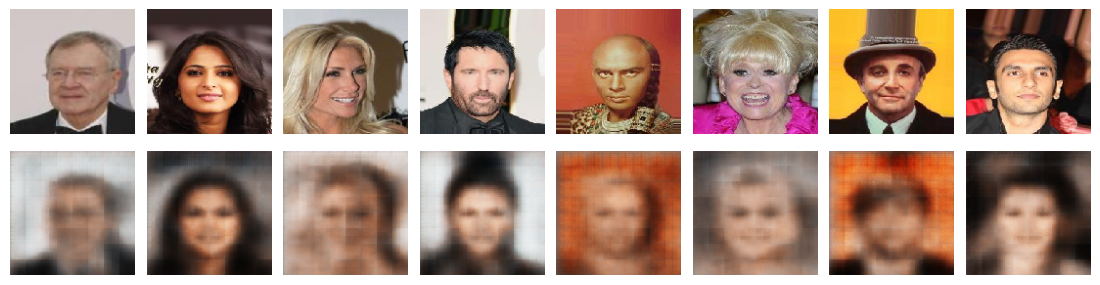

In [ ]:
# Reconstruction loss, the mean squared error between the input and output images
# Measures how well the VAE is able to reconstruct the input data from the learned latent representation
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

# KL divergence loss, calculates the divergence between the learned distribution and the prior.
# Used next for calculating the total_loss
# Measures the regularity of the learned latent representation
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

# Total loss, weighted sum of the reconstruction loss and the KL divergence loss (LOSS_FACTOR is configurable)
def total_loss(y_true, y_pred):
    return LOSS_FACTOR * r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

hist_loss = []
hist_r_loss = []
hist_kl_loss = []

adam_optimizer = Adam(learning_rate = LEARNING_RATE)

model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

# Takes 8 images to show the results during training
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:8]

# Just run one epoch and plot the images
model.fit(data_flow, 
    shuffle=True, 
    epochs = 1, 
    initial_epoch = 0, 
    steps_per_epoch=NUM_IMAGES / BATCH_SIZE)

plot_compare_VAE(vae_encoder, vae_decoder, model, example_images) 
# lr=0.0005 = 25min

Total Epoch: 1
Epoch 1/8
791/791 [==============================] - 559s 706ms/step - batch: 395.5000 - size: 255.8068 - loss: 236.8978 - r_loss: 0.0180 - kl_loss: 56.8268
Epoch 2/8
791/791 [==============================] - 149s 189ms/step - batch: 395.5000 - size: 255.8068 - loss: 223.5457 - r_loss: 0.0165 - kl_loss: 58.9313
Epoch 3/8
791/791 [==============================] - 149s 188ms/step - batch: 395.5000 - size: 255.8068 - loss: 217.5872 - r_loss: 0.0158 - kl_loss: 59.6832
Epoch 4/8
791/791 [==============================] - 152s 192ms/step - batch: 395.5000 - size: 255.8068 - loss: 214.1435 - r_loss: 0.0154 - kl_loss: 59.9028
Epoch 5/8
791/791 [==============================] - 152s 192ms/step - batch: 395.5000 - size: 255.8068 - loss: 211.8586 - r_loss: 0.0152 - kl_loss: 60.0578
Epoch 6/8
791/791 [==============================] - 153s 194ms/step - batch: 395.5000 - size: 255.8068 - loss: 210.0619 - r_loss: 0.0150 - kl_loss: 60.1682
Epoch 7/8
791/791 [========================

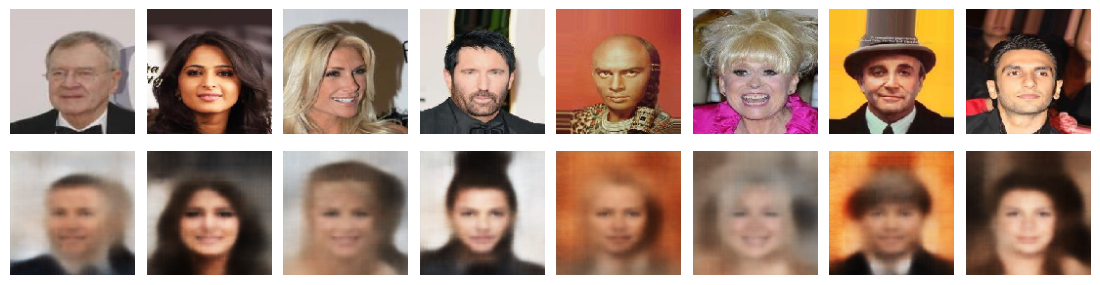

Total Epoch: 9
Epoch 1/8
791/791 [==============================] - 153s 193ms/step - batch: 395.5000 - size: 255.8068 - loss: 206.4228 - r_loss: 0.0146 - kl_loss: 60.4277
Epoch 2/8
791/791 [==============================] - 173s 218ms/step - batch: 395.5000 - size: 255.8068 - loss: 205.5823 - r_loss: 0.0145 - kl_loss: 60.4533
Epoch 3/8
791/791 [==============================] - 171s 216ms/step - batch: 395.5000 - size: 255.8068 - loss: 204.8467 - r_loss: 0.0144 - kl_loss: 60.4695
Epoch 4/8
791/791 [==============================] - 166s 210ms/step - batch: 395.5000 - size: 255.8068 - loss: 204.2069 - r_loss: 0.0144 - kl_loss: 60.4899
Epoch 5/8
791/791 [==============================] - 168s 212ms/step - batch: 395.5000 - size: 255.8068 - loss: 203.6691 - r_loss: 0.0143 - kl_loss: 60.5063
Epoch 6/8
791/791 [==============================] - 167s 211ms/step - batch: 395.5000 - size: 255.8068 - loss: 203.1351 - r_loss: 0.0143 - kl_loss: 60.4903
Epoch 7/8
791/791 [========================

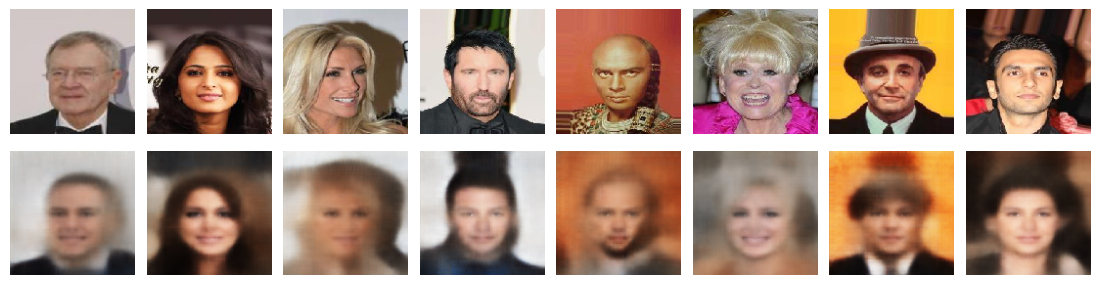

Total Epoch: 17
Epoch 1/8
791/791 [==============================] - 173s 218ms/step - batch: 395.5000 - size: 255.8068 - loss: 202.0121 - r_loss: 0.0142 - kl_loss: 60.4823
Epoch 2/8
791/791 [==============================] - 170s 214ms/step - batch: 395.5000 - size: 255.8068 - loss: 201.6907 - r_loss: 0.0141 - kl_loss: 60.4548
Epoch 3/8
791/791 [==============================] - 172s 217ms/step - batch: 395.5000 - size: 255.8068 - loss: 201.4890 - r_loss: 0.0141 - kl_loss: 60.4768
Epoch 4/8
791/791 [==============================] - 180s 227ms/step - batch: 395.5000 - size: 255.8068 - loss: 201.1776 - r_loss: 0.0141 - kl_loss: 60.4464
Epoch 5/8
791/791 [==============================] - 169s 213ms/step - batch: 395.5000 - size: 255.8068 - loss: 200.9492 - r_loss: 0.0141 - kl_loss: 60.4380
Epoch 6/8
791/791 [==============================] - 158s 199ms/step - batch: 395.5000 - size: 255.8068 - loss: 200.7494 - r_loss: 0.0140 - kl_loss: 60.4191
Epoch 7/8
791/791 [=======================

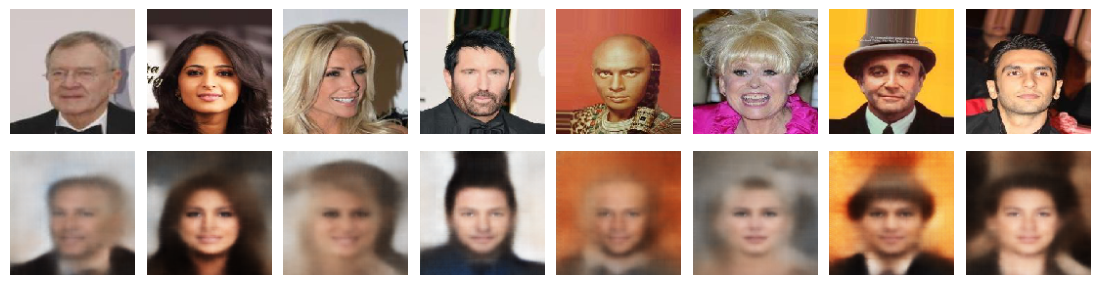

Total Epoch: 25
Epoch 1/8
791/791 [==============================] - 160s 202ms/step - batch: 395.5000 - size: 255.8068 - loss: 200.1763 - r_loss: 0.0140 - kl_loss: 60.4204
Epoch 2/8
791/791 [==============================] - 155s 196ms/step - batch: 395.5000 - size: 255.8068 - loss: 200.0467 - r_loss: 0.0140 - kl_loss: 60.4086
Epoch 3/8
791/791 [==============================] - 160s 203ms/step - batch: 395.5000 - size: 255.8068 - loss: 199.9022 - r_loss: 0.0139 - kl_loss: 60.4234
Epoch 4/8
791/791 [==============================] - 158s 199ms/step - batch: 395.5000 - size: 255.8068 - loss: 199.7389 - r_loss: 0.0139 - kl_loss: 60.3983
Epoch 5/8
791/791 [==============================] - 162s 204ms/step - batch: 395.5000 - size: 255.8068 - loss: 199.6274 - r_loss: 0.0139 - kl_loss: 60.4201
Epoch 6/8
791/791 [==============================] - 156s 197ms/step - batch: 395.5000 - size: 255.8068 - loss: 199.4767 - r_loss: 0.0139 - kl_loss: 60.4139
Epoch 7/8
791/791 [=======================

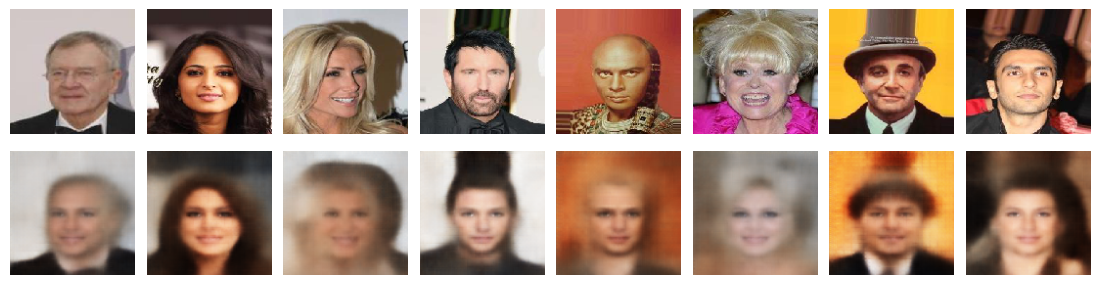

Total Epoch: 33
Epoch 1/8
791/791 [==============================] - 1235s 2s/step - batch: 395.5000 - size: 255.8068 - loss: 199.1582 - r_loss: 0.0139 - kl_loss: 60.3950
Epoch 2/8
791/791 [==============================] - 522s 659ms/step - batch: 395.5000 - size: 255.8068 - loss: 199.0355 - r_loss: 0.0139 - kl_loss: 60.3850
Epoch 3/8
791/791 [==============================] - 169s 214ms/step - batch: 395.5000 - size: 255.8068 - loss: 198.9420 - r_loss: 0.0139 - kl_loss: 60.3893
Epoch 4/8
791/791 [==============================] - 177s 224ms/step - batch: 395.5000 - size: 255.8068 - loss: 198.8899 - r_loss: 0.0138 - kl_loss: 60.3898
Epoch 5/8
791/791 [==============================] - 156s 197ms/step - batch: 395.5000 - size: 255.8068 - loss: 198.7697 - r_loss: 0.0138 - kl_loss: 60.3826
Epoch 6/8
791/791 [==============================] - 159s 201ms/step - batch: 395.5000 - size: 255.8068 - loss: 198.6949 - r_loss: 0.0138 - kl_loss: 60.3880
Epoch 7/8
791/791 [=========================

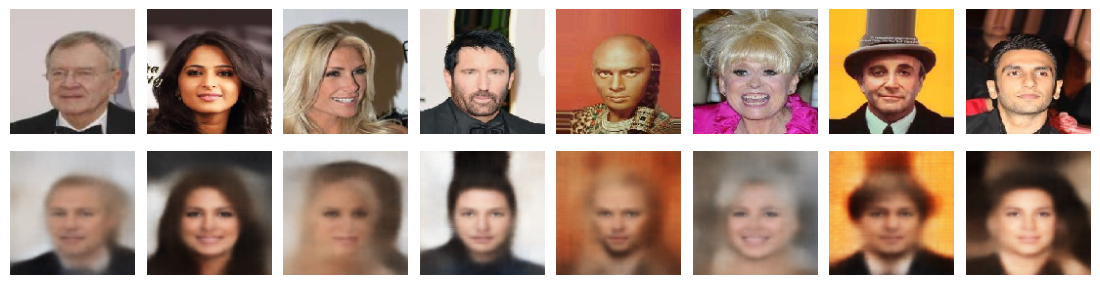

Total Epoch: 41
Epoch 1/8
791/791 [==============================] - 159s 201ms/step - batch: 395.5000 - size: 255.8068 - loss: 198.4729 - r_loss: 0.0138 - kl_loss: 60.4000
Epoch 2/8
791/791 [==============================] - 160s 203ms/step - batch: 395.5000 - size: 255.8068 - loss: 198.3320 - r_loss: 0.0138 - kl_loss: 60.3598
Epoch 3/8
791/791 [==============================] - 161s 203ms/step - batch: 395.5000 - size: 255.8068 - loss: 198.3312 - r_loss: 0.0138 - kl_loss: 60.4035
Epoch 4/8
791/791 [==============================] - 159s 200ms/step - batch: 395.5000 - size: 255.8068 - loss: 198.2648 - r_loss: 0.0138 - kl_loss: 60.4079
Epoch 5/8
791/791 [==============================] - 161s 203ms/step - batch: 395.5000 - size: 255.8068 - loss: 198.1862 - r_loss: 0.0138 - kl_loss: 60.4130
Epoch 6/8
791/791 [==============================] - 161s 203ms/step - batch: 395.5000 - size: 255.8068 - loss: 198.1508 - r_loss: 0.0138 - kl_loss: 60.4015
Epoch 7/8
791/791 [=======================

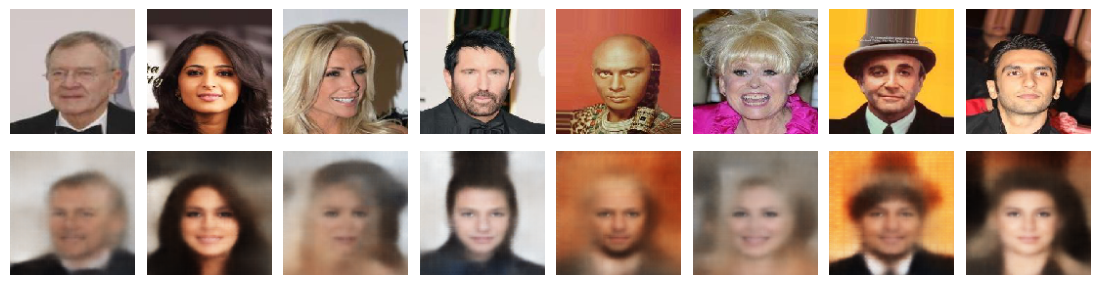

Total Epoch: 49
Epoch 1/8
791/791 [==============================] - 168s 212ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.9854 - r_loss: 0.0138 - kl_loss: 60.4157
Epoch 2/8
791/791 [==============================] - 178s 225ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.8745 - r_loss: 0.0137 - kl_loss: 60.3849
Epoch 3/8
791/791 [==============================] - 170s 215ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.8641 - r_loss: 0.0137 - kl_loss: 60.4082
Epoch 4/8
791/791 [==============================] - 170s 215ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.8283 - r_loss: 0.0137 - kl_loss: 60.4196
Epoch 5/8
791/791 [==============================] - 171s 216ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.7664 - r_loss: 0.0137 - kl_loss: 60.4136
Epoch 6/8
791/791 [==============================] - 172s 217ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.7249 - r_loss: 0.0137 - kl_loss: 60.4183
Epoch 7/8
791/791 [=======================

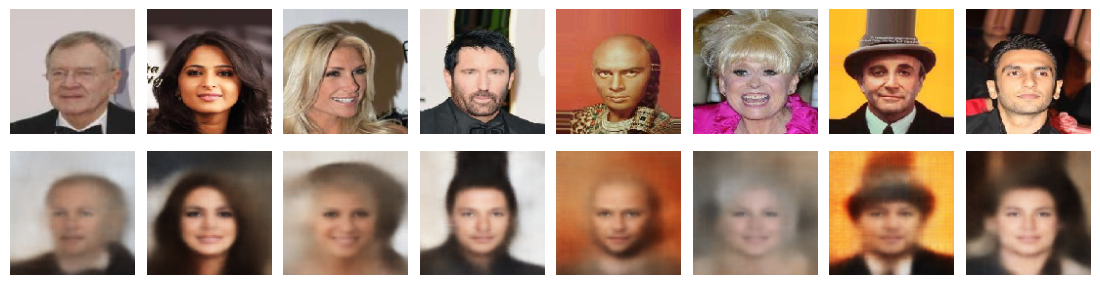

Total Epoch: 57
Epoch 1/8
791/791 [==============================] - 177s 223ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.5990 - r_loss: 0.0137 - kl_loss: 60.4211
Epoch 2/8
791/791 [==============================] - 169s 213ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.5475 - r_loss: 0.0137 - kl_loss: 60.3885
Epoch 3/8
791/791 [==============================] - 161s 203ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.5555 - r_loss: 0.0137 - kl_loss: 60.4309
Epoch 4/8
791/791 [==============================] - 159s 201ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.4541 - r_loss: 0.0137 - kl_loss: 60.4195
Epoch 5/8
791/791 [==============================] - 164s 207ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.4399 - r_loss: 0.0137 - kl_loss: 60.4364
Epoch 6/8
791/791 [==============================] - 161s 203ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.3971 - r_loss: 0.0137 - kl_loss: 60.4177
Epoch 7/8
791/791 [=======================

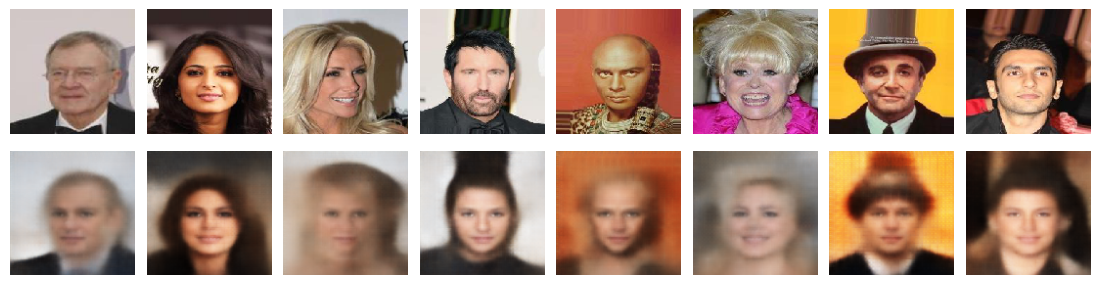

Total Epoch: 65
Epoch 1/8
791/791 [==============================] - 159s 201ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.3118 - r_loss: 0.0137 - kl_loss: 60.4169
Epoch 2/8
791/791 [==============================] - 156s 197ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.2505 - r_loss: 0.0137 - kl_loss: 60.4217
Epoch 3/8
791/791 [==============================] - 154s 195ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.2324 - r_loss: 0.0137 - kl_loss: 60.4173
Epoch 4/8
791/791 [==============================] - 160s 202ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.1864 - r_loss: 0.0137 - kl_loss: 60.4125
Epoch 5/8
791/791 [==============================] - 165s 209ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.1716 - r_loss: 0.0137 - kl_loss: 60.4200
Epoch 6/8
791/791 [==============================] - 176s 222ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.1196 - r_loss: 0.0137 - kl_loss: 60.4074
Epoch 7/8
791/791 [=======================

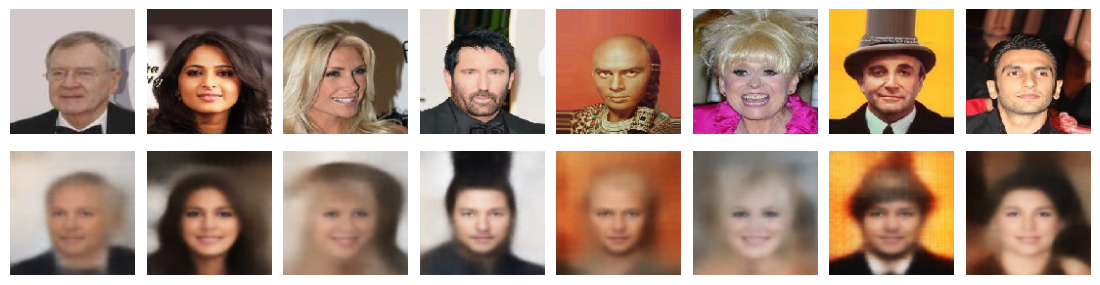

Total Epoch: 73
Epoch 1/8
791/791 [==============================] - 175s 221ms/step - batch: 395.5000 - size: 255.8068 - loss: 197.0454 - r_loss: 0.0137 - kl_loss: 60.4104
Epoch 2/8
791/791 [==============================] - 168s 213ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.9869 - r_loss: 0.0137 - kl_loss: 60.4190
Epoch 3/8
791/791 [==============================] - 169s 213ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.9616 - r_loss: 0.0137 - kl_loss: 60.4163
Epoch 4/8
791/791 [==============================] - 175s 221ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.9753 - r_loss: 0.0137 - kl_loss: 60.4394
Epoch 5/8
791/791 [==============================] - 179s 226ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.9510 - r_loss: 0.0137 - kl_loss: 60.4291
Epoch 6/8
791/791 [==============================] - 172s 217ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.9252 - r_loss: 0.0136 - kl_loss: 60.4242
Epoch 7/8
791/791 [=======================

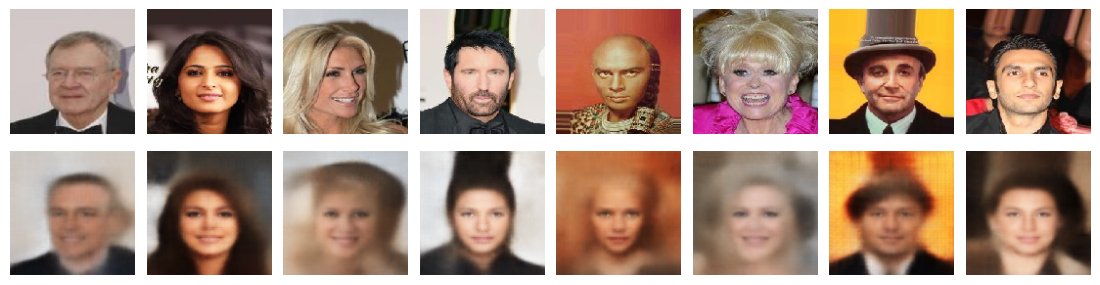

Total Epoch: 81
Epoch 1/8
791/791 [==============================] - 163s 206ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.8605 - r_loss: 0.0136 - kl_loss: 60.4538
Epoch 2/8
791/791 [==============================] - 161s 204ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.7710 - r_loss: 0.0136 - kl_loss: 60.4044
Epoch 3/8
791/791 [==============================] - 159s 201ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.8254 - r_loss: 0.0136 - kl_loss: 60.4273
Epoch 4/8
791/791 [==============================] - 156s 197ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.7871 - r_loss: 0.0136 - kl_loss: 60.4485
Epoch 5/8
791/791 [==============================] - 159s 201ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.7636 - r_loss: 0.0136 - kl_loss: 60.4392
Epoch 6/8
791/791 [==============================] - 161s 203ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.7157 - r_loss: 0.0136 - kl_loss: 60.4275
Epoch 7/8
791/791 [=======================

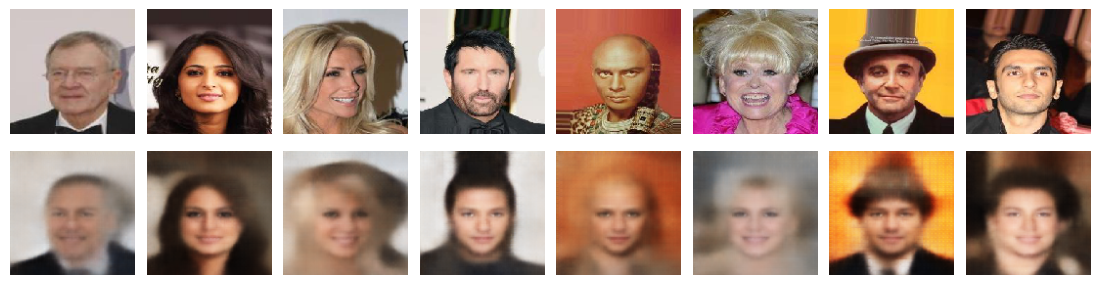

Total Epoch: 89
Epoch 1/8
791/791 [==============================] - 168s 212ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.6668 - r_loss: 0.0136 - kl_loss: 60.4473
Epoch 2/8
791/791 [==============================] - 183s 231ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.6402 - r_loss: 0.0136 - kl_loss: 60.4262
Epoch 3/8
791/791 [==============================] - 165s 208ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.6287 - r_loss: 0.0136 - kl_loss: 60.4344
Epoch 4/8
791/791 [==============================] - 168s 212ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.6260 - r_loss: 0.0136 - kl_loss: 60.4469
Epoch 5/8
791/791 [==============================] - 182s 230ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.5752 - r_loss: 0.0136 - kl_loss: 60.4250
Epoch 6/8
791/791 [==============================] - 166s 209ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.5753 - r_loss: 0.0136 - kl_loss: 60.4243
Epoch 7/8
791/791 [=======================

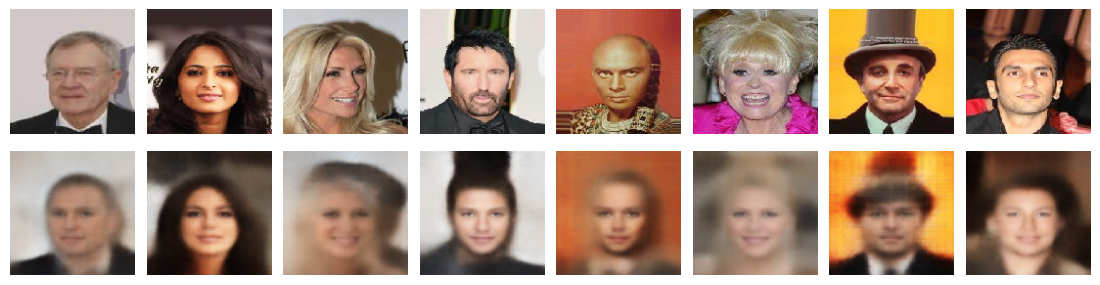

Total Epoch: 97
Epoch 1/8
791/791 [==============================] - 168s 212ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.5038 - r_loss: 0.0136 - kl_loss: 60.4209
Epoch 2/8
791/791 [==============================] - 173s 218ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.4829 - r_loss: 0.0136 - kl_loss: 60.4494
Epoch 3/8
791/791 [==============================] - 184s 232ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.4579 - r_loss: 0.0136 - kl_loss: 60.4347
Epoch 4/8
791/791 [==============================] - 170s 215ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.4461 - r_loss: 0.0136 - kl_loss: 60.4341
Epoch 5/8
791/791 [==============================] - 170s 215ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.4486 - r_loss: 0.0136 - kl_loss: 60.4461
Epoch 6/8
791/791 [==============================] - 176s 222ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.3865 - r_loss: 0.0136 - kl_loss: 60.4312
Epoch 7/8
791/791 [=======================

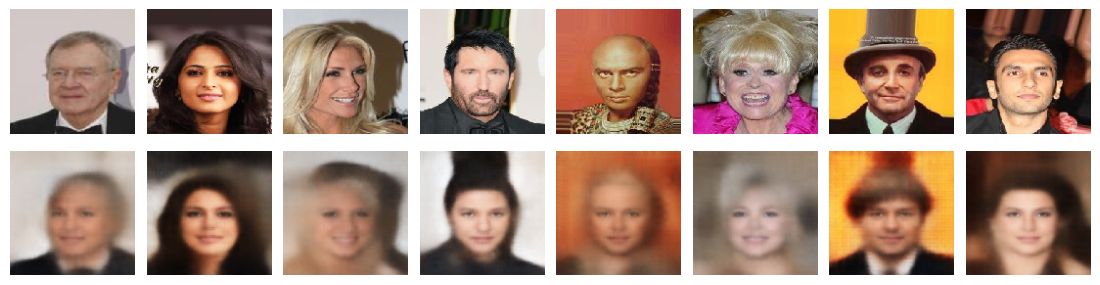

Total Epoch: 105
Epoch 1/8
791/791 [==============================] - 161s 204ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.3579 - r_loss: 0.0136 - kl_loss: 60.4291
Epoch 2/8
791/791 [==============================] - 157s 199ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.3320 - r_loss: 0.0136 - kl_loss: 60.4284
Epoch 3/8
791/791 [==============================] - 153s 194ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.3382 - r_loss: 0.0136 - kl_loss: 60.4337
Epoch 4/8
791/791 [==============================] - 159s 201ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.2821 - r_loss: 0.0136 - kl_loss: 60.4149
Epoch 5/8
791/791 [==============================] - 159s 201ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.2708 - r_loss: 0.0136 - kl_loss: 60.4336
Epoch 6/8
791/791 [==============================] - 158s 200ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.2742 - r_loss: 0.0136 - kl_loss: 60.4556
Epoch 7/8
791/791 [======================

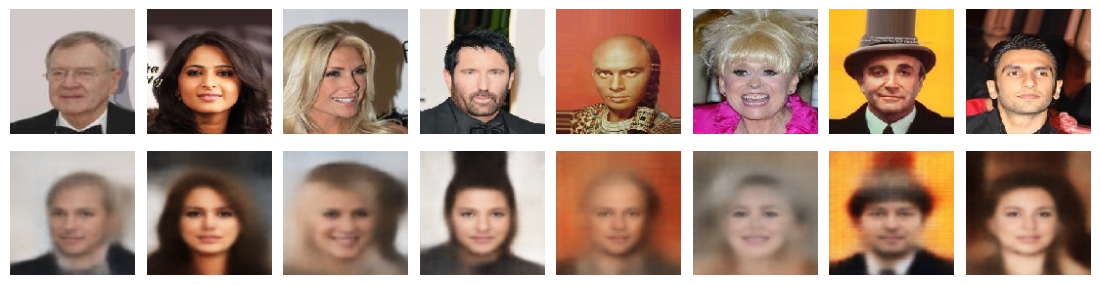

Total Epoch: 113
Epoch 1/8
791/791 [==============================] - 171s 215ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.2179 - r_loss: 0.0136 - kl_loss: 60.4174
Epoch 2/8
791/791 [==============================] - 166s 210ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.2335 - r_loss: 0.0136 - kl_loss: 60.4422
Epoch 3/8
791/791 [==============================] - 168s 212ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.1986 - r_loss: 0.0136 - kl_loss: 60.4559
Epoch 4/8
791/791 [==============================] - 177s 224ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.1509 - r_loss: 0.0136 - kl_loss: 60.4380
Epoch 5/8
791/791 [==============================] - 177s 223ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.1647 - r_loss: 0.0136 - kl_loss: 60.4288
Epoch 6/8
791/791 [==============================] - 167s 211ms/step - batch: 395.5000 - size: 255.8068 - loss: 196.1356 - r_loss: 0.0136 - kl_loss: 60.4613
Epoch 7/8
791/791 [======================

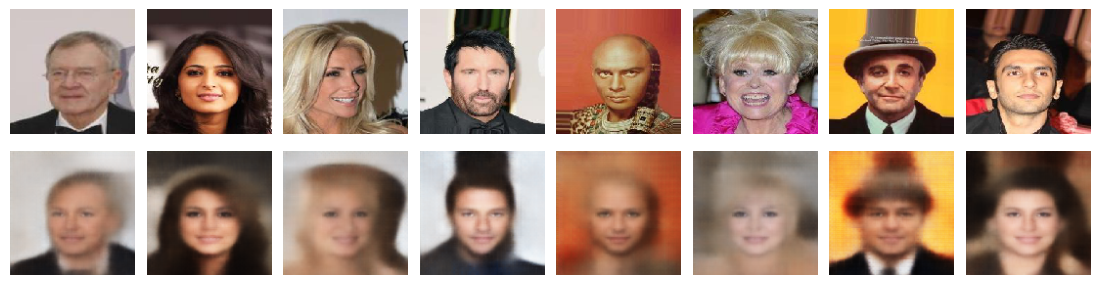

In [ ]:
tot_epoch = 1
# For each block train the model for a number of epochs and show the partial images
for i in range(N_BLOCKS):
    print("Total Epoch:", tot_epoch)
    hist = model.fit(data_flow, 
        shuffle=True, 
        epochs = N_EPOCHS, 
        initial_epoch = 0, 
        steps_per_epoch=NUM_IMAGES / BATCH_SIZE)
    hist_loss.append(hist.history['loss'])
    hist_r_loss.append(hist.history['r_loss'])
    hist_kl_loss.append(hist.history['kl_loss'])

    plot_compare_VAE(vae_encoder, vae_decoder, model, example_images) 

    tot_epoch = tot_epoch + N_EPOCHS

# Save the model in case we want to use it later or keep training it
model.save(os.path.join(WEIGHTS_FOLDER, 'VAE/model_1.h5'))

#lr=0.0005=597,180 - 120 epochs=360 min

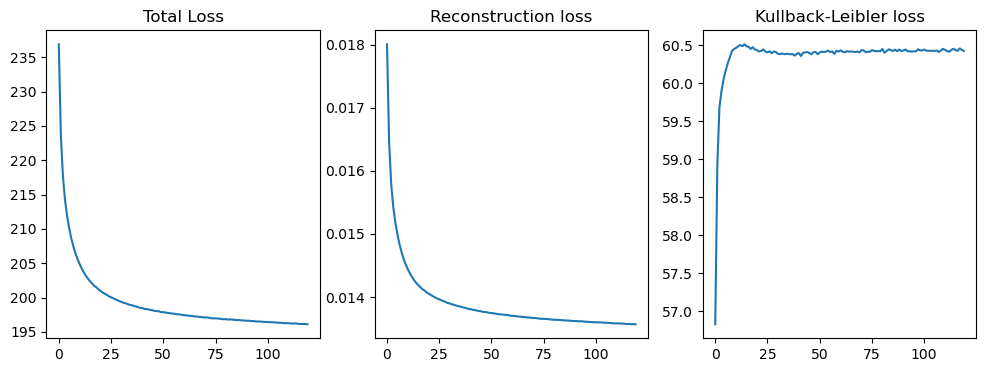

In [ ]:
plot_losses(hist_loss, hist_r_loss, hist_kl_loss)

## 4. Results and Conclusions

show the images
show the loss?